# Model

This is the full model, with all functions written inside the main class function. Detailed explaination of steps will be listed below in separate sections to run in individual Jupyter Notebook cells.

In [ ]:
import re
from collections import defaultdict
import math

class NGramLanguageModel:
    def __init__(self, n=2):
        self.n = n
        self.ngram_counts = defaultdict(int)
        self.context_counts = defaultdict(int)
        self.vocab = set()

    def preprocess(self, text):
        # Preserve 'US' by replacing it with a placeholder before any transformation
        input = re.sub(r'\bUS\b', 'US_placeholder', text)

        # Convert input to lowercase but preserve "US"
        input_lower = input.lower()

        # Handle prices to preserve the number before '/'
        input_lower = re.sub(r'\b(\d+)/([a-zA-Z]+)', r'\1 per \2', input_lower)  # Separate number from '/night' or similar, replace / to per

        # Simplify URLs to a placeholder
        input_lower = re.sub(r'//[^ ]+', 'URL', input_lower)

        # Split phrases like attractions/shopping into separate words
        input_lower = re.sub(r'(\D+)/(\D+)', r'\1 \2', input_lower)  # Tokenize phrases separated by '/'

        # Now replace 'us' with lowercase and handle special cases
        input_lower = re.sub(r'\bus\b', 'us', input_lower)  # Ensure 'us' remains as 'us'

        # Replace dates with the token 'calendardate'
        input_lower = re.sub(r'\b(\d{1,2})/(\d{1,2})/(\d{2,4})\b', 'calendardate', input_lower)  # Match dates like 9/5/2009

        # Restore 'US' from the placeholder
        input_lower = input_lower.replace('us_placeholder', 'US')

        # Replace n't, 'll, 's, 're, 've
        input_lower = input_lower.replace('n\'t', 'not')
        input_lower = input_lower.replace('\'ll', 'will')
        input_lower = input_lower.replace('\'s', 'is')
        input_lower = input_lower.replace('\'re', 'are')
        input_lower = input_lower.replace('\'ve', 'have')

        # Remove special characters but keep whitespace and alpha
        cleaned = ''.join(char for char in input_lower if char.isalpha() or char in "' /")  # Space included to separate words

        return cleaned.strip().split()

    def train(self, corpus):
        for line in corpus:
            tokens = self.preprocess(line)
            self.vocab.update(tokens)

            # Loop through each character and loop through previous characters for n > 1
            for i in range(len(tokens)):
                for j in range(1, self.n + 1):
                    if i + j <= len(tokens):    # Prevent overflow
                        ngram = tuple(tokens[i:i+j])
                        self.ngram_counts[ngram] += 1
                        if j > 1:
                            self.context_counts[ngram[:-1]] += 1
            # Make sure last token is added
            if self.n > 1:
                self.ngram_counts[tuple(tokens[-self.n:])] += 1

    def unsmoothed_probability(self, ngram):
        if len(ngram) == 1:
            total_count = sum(self.ngram_counts[t] for t in self.ngram_counts if len(t) == 1)
            return self.ngram_counts[ngram] / total_count if total_count > 0 else 0
        else:
            context = ngram[:-1]
            return self.ngram_counts[ngram] / self.context_counts[context] if self.context_counts[context] > 0 else 0

    def add_k_smoothing(self, ngram, k=0.1):
        if len(ngram) == 1:
            return (self.ngram_counts[ngram] + k) / (sum(self.ngram_counts[t] for t in self.ngram_counts if len(t) == 1) + k * len(self.vocab))
        else:
            context = ngram[:-1]
            return (self.ngram_counts[ngram] + k) / (self.context_counts[context] + k * len(self.vocab))

    def laplace_smoothing(self, ngram):
        return self.add_k_smoothing(ngram, k=1)

    def handle_unknown_words(self, word):
        return "<UNK>" if word not in self.vocab else word

    def perplexity(self, test_corpus, smoothing_method='', k=1):
        log_prob_sum = 0
        token_count = 0

        for line in test_corpus:
            tokens = self.preprocess(line)
            tokens = [self.handle_unknown_words(token) for token in tokens]
            token_count += len(tokens)

            for i in range(len(tokens)):
                context = tuple(tokens[max(0, i-self.n+1):i])
                ngram = context + (tokens[i],)

                if smoothing_method == 'laplace':
                    prob = self.laplace_smoothing(ngram)
                elif smoothing_method == 'add_k':
                    prob = self.add_k_smoothing(ngram, k)
                else:
                    prob = self.unsmoothed_probability(ngram)

                if prob > 0:
                    log_prob_sum += math.log(prob)
                else:
                    # Handle zero probability by assigning a very low log probability
                    log_prob_sum += math.log(1e-10)

        return math.exp(-log_prob_sum / token_count)

    def top_unigram_probabilities(self, n=10):
        unigram_probs = [(unigram[0], self.unsmoothed_probability(unigram))
                         for unigram in self.ngram_counts if len(unigram) == 1]

        return sorted(unigram_probs, key=lambda x: x[1], reverse=True)[:n]

    def test_one(self, term, smoothing_method='', k=1):
        if smoothing_method == 'laplace':
            return self.laplace_smoothing(term)
        elif smoothing_method == 'add_k':
            return self.add_k_smoothing(term, k)
        else:
            return self.unsmoothed_probability(term)

# Data Loading/Preprocessing

Upload the `A1_DATASET.zip` file from eLearning to the files.



In [ ]:
!unzip -o A1_DATASET.zip

unzip:  cannot find or open A1_DATASET.zip, A1_DATASET.zip.zip or A1_DATASET.zip.ZIP.


In [ ]:
# Load training data
with open('A1_DATASET/train.txt', 'r', encoding='utf-8') as f:
    train_corpus = f.readlines()

# Load validation data
with open('A1_DATASET/val.txt', 'r', encoding='utf-8') as f:
    validation_corpus = f.readlines()

## Preprocessing Explaination

- Keep alphabetic characters (convert all to lowercase) but keep `US` still `US city` rather than `us city`
- Process `'` (singular apostrophes) for contractions -- in the data, we see a lot of `n't`, `'ll`, `'d` etc. These can be important for context.
  - Replace `n't` to `not`, `'ll` to `will`, `'re` to `are`, `'ve` to `have` but keep `'d` unchanged since `'d`can not only be `would`, but also `had`, if not consider the whole sentence and contex, hard to decide.
- Process `/` (forward slashes) -- this is because there are 5 cases that forward slashes would be used:
    - Between numbers in fractions, like `1/2`
    - Between words used as "or" (eg. `clean/friendly`, `Housekeeping/Turn Down Service`), alternative words
    - Date, like `11/20`, or `11/13/2010`
    - Price, like `$ 58/night`
    - web link, like `//hotels.com`
- Remove all other characters
- Trim all remaining strings and filter out those that are empty

This pre-processing step will happen on each line of the dataset, whenever training or validation happens.

## Training

The "training" of this model is really just getting the counts of ngrams, as well as the counts of the respective "contexts" of the ngrams. For unigrams, this isn't needed as we simply divide by the total number of unique terms, but for unigrams we do need to keep track of the unigram prior, which is the context of the bigram in this case.

In [ ]:
# Train unigram model
unigram_model = NGramLanguageModel(n=1)
unigram_model.train(train_corpus)

# Train bigram model
bigram_model = NGramLanguageModel(n=2)
bigram_model.train(train_corpus)

In [ ]:
unigram_model.top_unigram_probabilities()

[('the', 0.06719557943830477),
 ('and', 0.03288806651120349),
 ('a', 0.028490317347662983),
 ('to', 0.026487884010950015),
 ('was', 0.023142046030619486),
 ('i', 0.021709925986008315),
 ('in', 0.01598144580756362),
 ('we', 0.014156443272837878),
 ('is', 0.013319983777755246),
 ('of', 0.01325661563418838)]

In [ ]:
bigram_model.test_one(('the', 'room'))

0.055649877381626106

In [ ]:
print(unigram_model.ngram_counts[('heartbeat',)])
print(bigram_model.context_counts[('heartbeat',)])

1
0


# Unsmoothed N-grams

We have calculated the unigram and bigram counts of the training set, stored in their respective counts array. We will then use these counts to calculate the perplexity of the model, without doing any smoothing. For all unknown words, we assign a very low log-probability so we don't end up with infinities when taking the log.

In [ ]:
# Calculate perplexity for unigram model
unigram_perplexity = unigram_model.perplexity(train_corpus)
print(f"Unsmoothed Unigram model perplexity: {unigram_perplexity}")

# Calculate perplexity for bigram model
bigram_perplexity = bigram_model.perplexity(train_corpus)
print(f"Unsmoothed Bigram model perplexity: {bigram_perplexity}")

Unsmoothed Unigram model perplexity: 494.2791347604311
Unsmoothed Bigram model perplexity: 30.782797233064187


In [ ]:
# Calculate perplexity for unigram model
unigram_perplexity = unigram_model.perplexity(validation_corpus)
print(f"Unsmoothed Unigram model perplexity: {unigram_perplexity}")

# Calculate perplexity for bigram model
bigram_perplexity = bigram_model.perplexity(validation_corpus)
print(f"Unsmoothed Bigram model perplexity: {bigram_perplexity}")

Unsmoothed Unigram model perplexity: 720.5399781710248
Unsmoothed Bigram model perplexity: 25582.713906712


# Smoothing

To handle unknown words, we replace them with the `<UNKNOWN>` keyword. To perform smoothing, we use Laplace Smoothing as well as a series of add-k smoothing, with differing values of k.

In [ ]:
# Calculate perplexity for unigram model with laplace smoothing
unigram_laplace_perplexity = unigram_model.perplexity(validation_corpus, smoothing_method='laplace')
print(f"Unigram model perplexity with Laplace smoothing: {unigram_laplace_perplexity}")

# Calculate perplexity for bigram model with laplace smoothing
bigram_laplace_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='laplace')
print(f"Bigram model perplexity with Laplace smoothing: {bigram_laplace_perplexity}")

# Calculate perplexity for unigram model with add-k smoothing (of different k values
unigram_add_k_perplexity = unigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.1)
print(f"Unigram model perplexity with add-k (k=0.1) smoothing: {unigram_add_k_perplexity}")

unigram_add_k_perplexity = unigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.05)
print(f"Unigram model perplexity with add-k (k=0.05) smoothing: {unigram_add_k_perplexity}")

# Calculate perplexity for bigram model with add-k smoothing (of different k values
bigram_add_k_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.1)
print(f"Bigram model perplexity with add-k (k=0.1) smoothing: {bigram_add_k_perplexity}")

bigram_add_k_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.05)
print(f"Bigram model perplexity with add-k (k=0.05) smoothing: {bigram_add_k_perplexity}")

bigram_add_k_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.01)
print(f"Bigram model perplexity with add-k (k=0.01) smoothing: {bigram_add_k_perplexity}")

bigram_add_k_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.005)
print(f"Bigram model perplexity with add-k (k=0.005) smoothing: {bigram_add_k_perplexity}")

bigram_add_k_perplexity = bigram_model.perplexity(validation_corpus, smoothing_method='add_k', k=0.001)
print(f"Bigram model perplexity with add-k (k=0.001) smoothing: {bigram_add_k_perplexity}")

Unigram model perplexity with Laplace smoothing: 513.1057379235663
Bigram model perplexity with Laplace smoothing: 1189.9708957449484
Unigram model perplexity with add-k (k=0.1) smoothing: 537.4355160606028
Unigram model perplexity with add-k (k=0.05) smoothing: 548.5980688072752
Bigram model perplexity with add-k (k=0.1) smoothing: 489.42475249933585
Bigram model perplexity with add-k (k=0.05) smoothing: 413.19023790252487
Bigram model perplexity with add-k (k=0.01) smoothing: 348.5153193289591
Bigram model perplexity with add-k (k=0.005) smoothing: 354.9874579340956
Bigram model perplexity with add-k (k=0.001) smoothing: 440.4381085098001


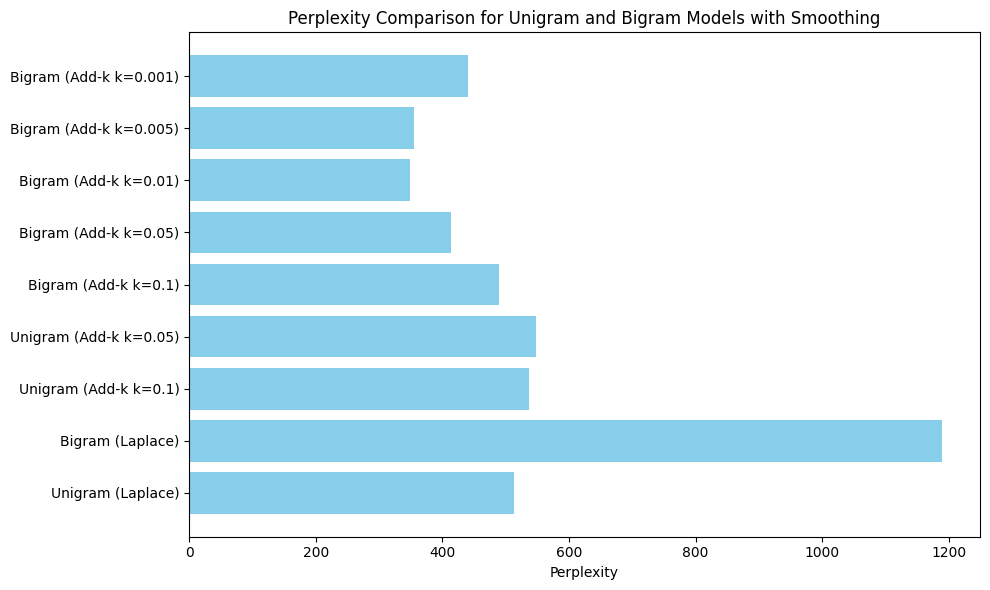

In [ ]:
import matplotlib.pyplot as plt

perplexity_values = {
    "Unigram (Laplace)": 513.11,
    "Bigram (Laplace)": 1189.97,
    "Unigram (Add-k k=0.1)": 537.44,
    "Unigram (Add-k k=0.05)": 548.60,
    "Bigram (Add-k k=0.1)": 489.42,
    "Bigram (Add-k k=0.05)": 413.19,
    "Bigram (Add-k k=0.01)": 348.52,
    "Bigram (Add-k k=0.005)": 354.99,
    "Bigram (Add-k k=0.001)": 440.44,
}

labels = list(perplexity_values.keys())
values = list(perplexity_values.values())

plt.figure(figsize=(10, 6))
plt.barh(labels, values, color="skyblue")
plt.xlabel("Perplexity")
plt.title("Perplexity Comparison for Unigram and Bigram Models with Smoothing")
plt.tight_layout()

plt.show()